# Produced Water Optimization Demo

The following demo has been designed to illustrate how DOE’s new produced water optimization software can be used for decision-support and/or analysis. 

## The Setup

We assume that the following __network schematic__ (or "superstructure") represents the characteristics of a given produced water system. 

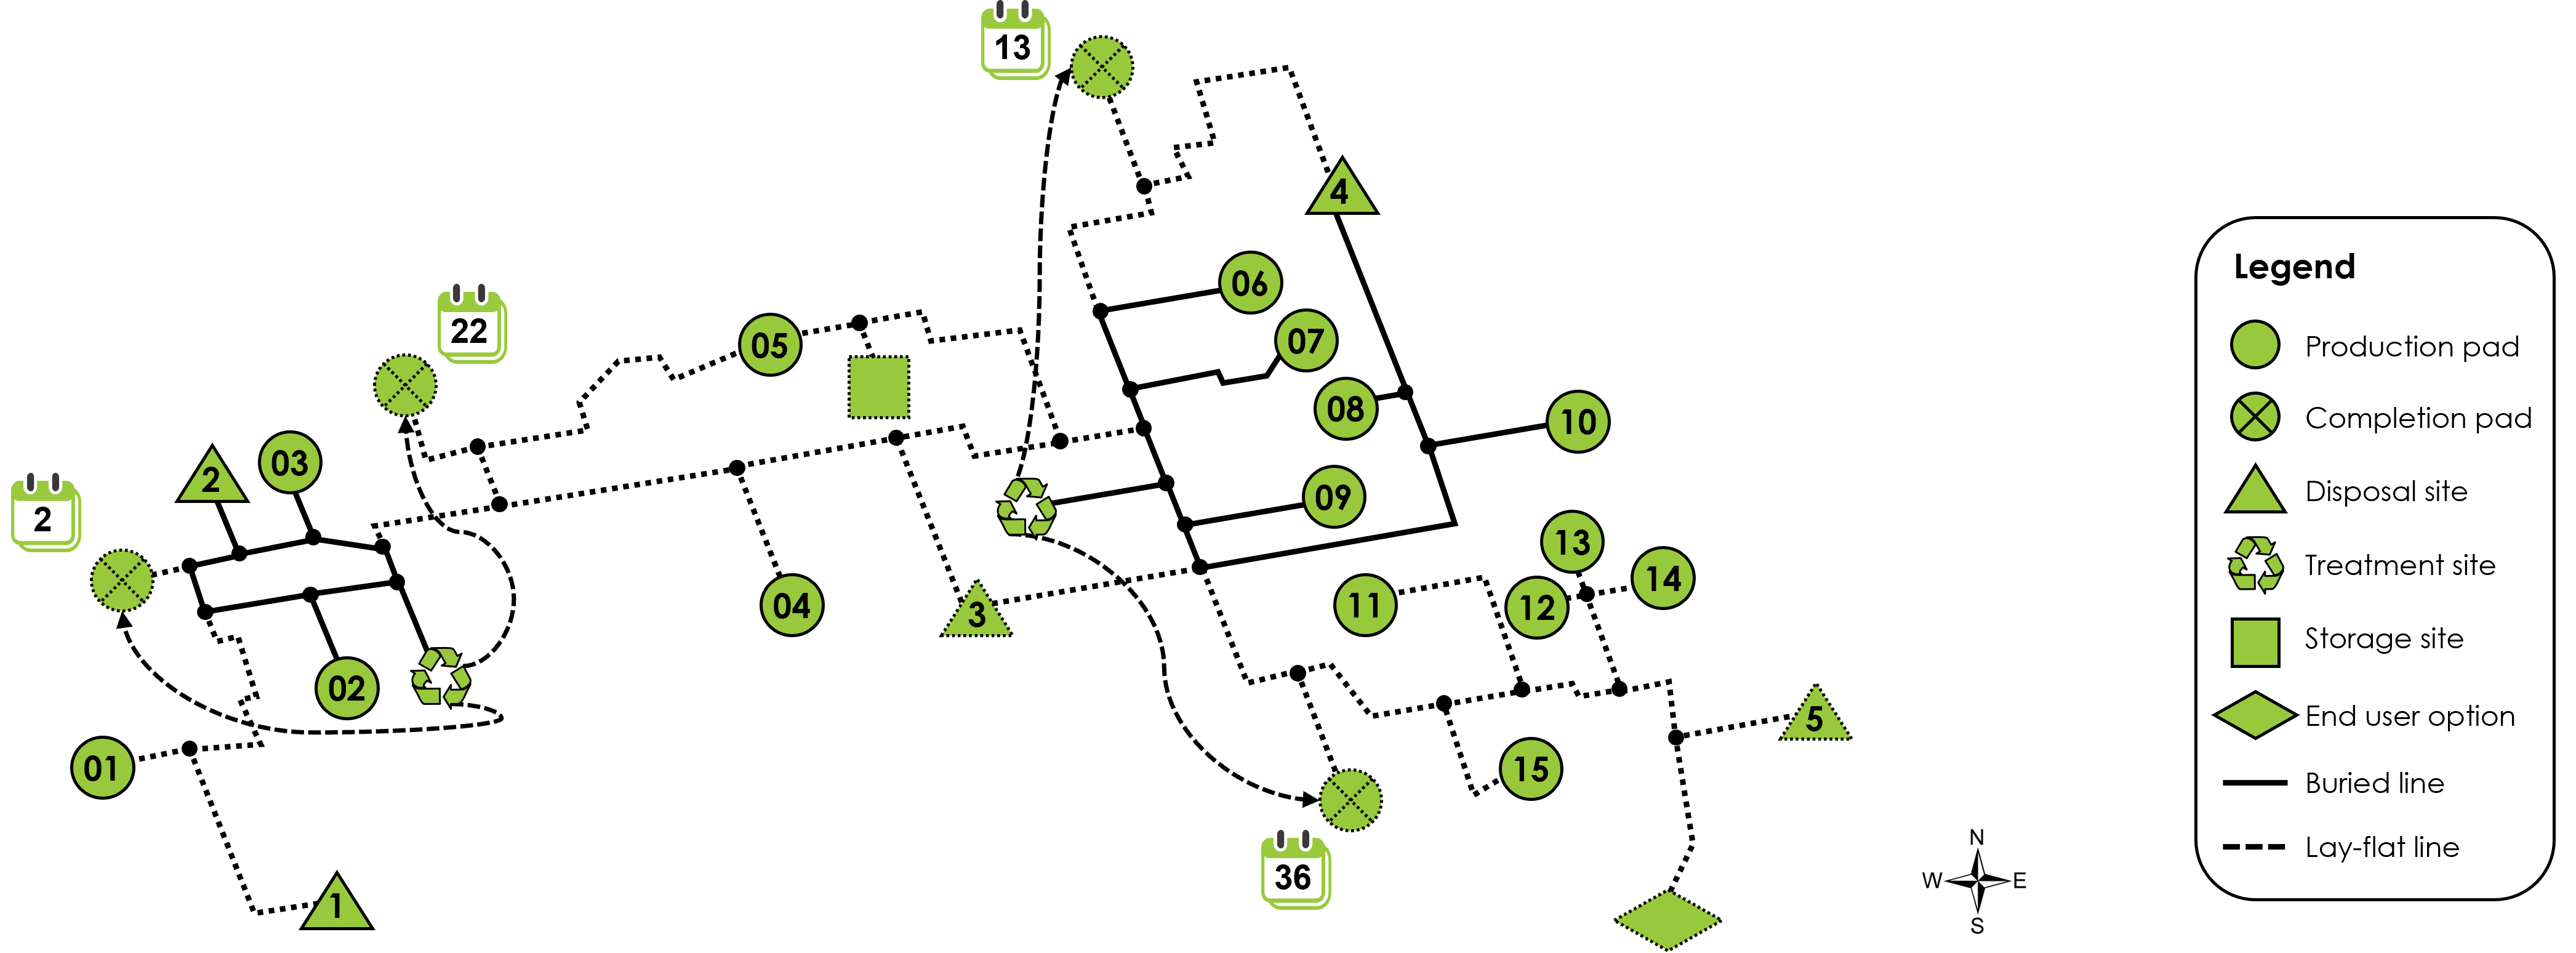

## Setting Up the Optimization Framework

To construct the basic network model architecture, we import several optimization-related __Python__ packages. For more information on these components, please refer to the __Pyomo__ documentation in particular: 
https://pyomo.readthedocs.io/en/latest/

Next, we define the __contextual elements__ of the water network:
- __Production pads__ PP01-PP15
- __Completions pads__ CP01-CP04
- __Disposal sites__ K01-K05
- __Treatment centers__ R01-R02
- __Storage facility__ SS01
- __Network nodes__ N01-N29

The image below clearly identifies each respective element within the network. 

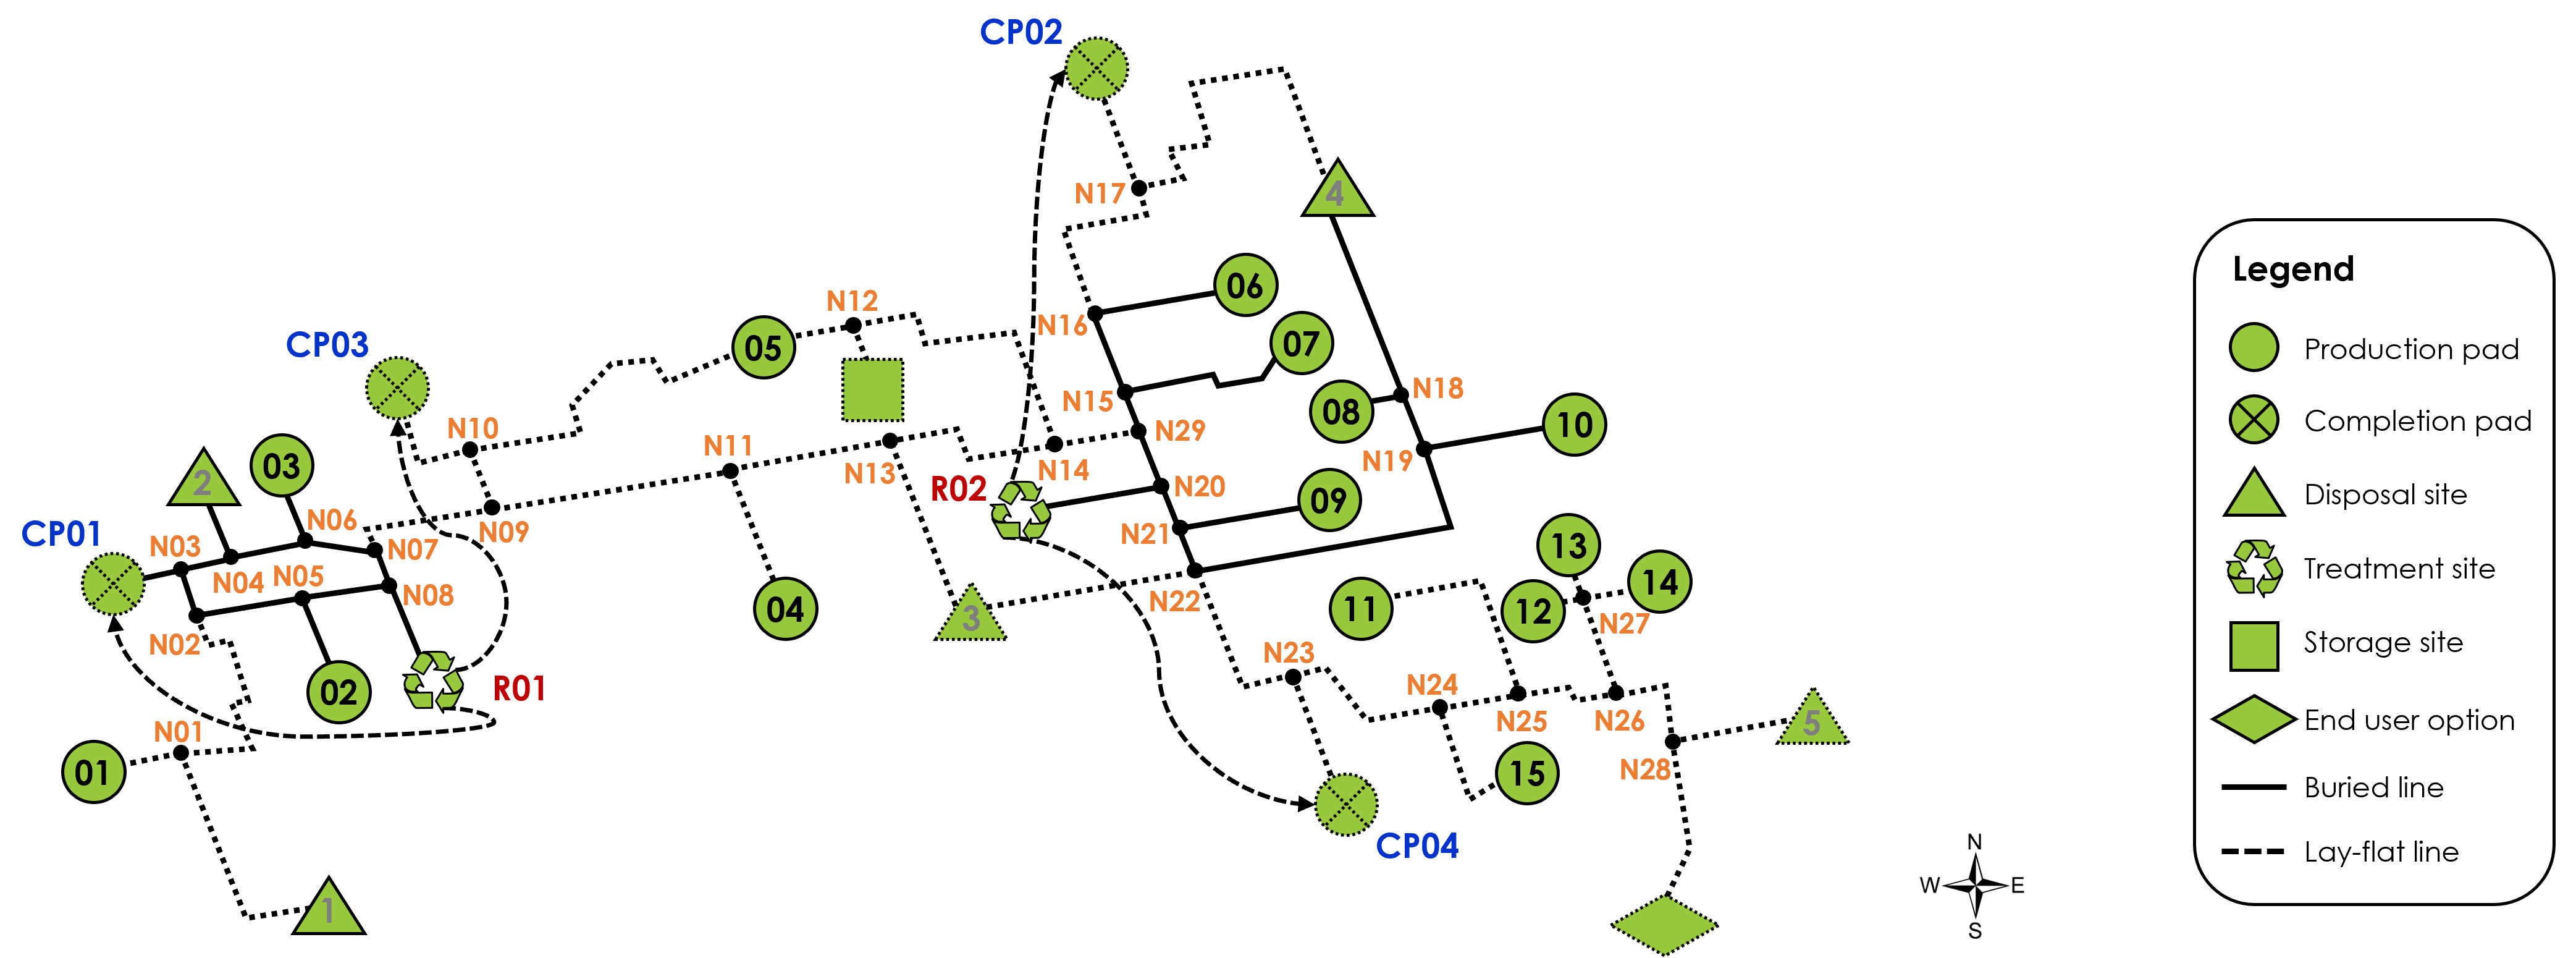

## Loading Data into the Program

First, we load network- and scenario-specific __input data__ into the optimization program. This data can easily by modified by program users. By default, the program will read data from a __pre-formatted spreadsheet__.

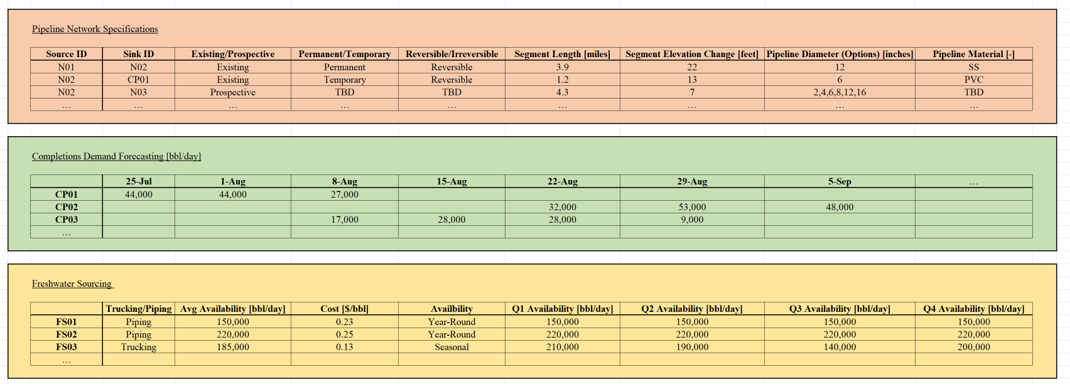

In [1]:
## Read pareto, pyomo, and python libraries ##
from pyomo.environ import (Var, Param, Set, ConcreteModel, Constraint, SolverFactory)
from pareto.strategic_water_management.strategic_produced_water_optimization import (
    create_variables,
    create_model,
    Objectives,
)
from idaes.core.util.misc import get_solver
from pareto.utilities.get_data import get_data
from pareto.utilities.results import generate_report, PrintValues

import pandas as pd

fname='input_data_generic_strategic_case_study_LAYFLAT_FULL.xlsx'

set_list = [
    "ProductionPads",
    "ProductionTanks",
    "CompletionsPads",
    "SWDSites",
    "FreshwaterSources",
    "StorageSites",
    "TreatmentSites",
    "ReuseOptions",
    "NetworkNodes",
    "PipelineDiameters",
    "StorageCapacities",
    "InjectionCapacities",
    "TreatmentCapacities",
]

parameter_list = ["PNA", "CNA", "CCA", "NNA", "NCA", "NKA", "NRA", "NSA", "FCA", "RCA", "RNA", "SNA", "PCT", "PKT", "FCT", 
                  "CST", "CCT", "CKT", "TruckingTime", "CompletionsDemand", "PadRates", "FlowbackRates", "InitialPipelineCapacity",
                  "InitialDisposalCapacity", "InitialTreatmentCapacity", "FreshwaterSourcingAvailability", "PadOffloadingCapacity",
                  "CompletionsPadStorage", "DisposalOperationalCost", "TreatmentOperationalCost", "ReuseOperationalCost",
                  "PipelineOperationalCost", "FreshSourcingCost", "TruckingHourlyCost", "PipelineCapacityIncrements",
                  "DisposalCapacityIncrements", "InitialStorageCapacity", "StorageCapacityIncrements", "TreatmentCapacityIncrements",
                  "TreatmentEfficiency", "DisposalExpansionCost", "StorageExpansionCost", "TreatmentExpansionCost","PipelineExpansionCost",]

## Import data from Excel ##
df_sets, df_parameters = get_data(fname, set_list, parameter_list)

## Create mathematical model ##
model = ConcreteModel()

## Define sets ##
model.s_T  = Set(initialize = df_sets['TimePeriods'], doc='Time Periods', ordered=True)
model.s_PP = Set(initialize = df_sets['ProductionPads'], doc='Production Pads')
model.s_CP = Set(initialize = df_sets['CompletionsPads'], doc='Completions Pads')
model.s_P  = Set(initialize = (model.s_PP | model.s_CP), doc='Pads')
model.s_F  = Set(initialize = df_sets['FreshwaterSources'], doc='Freshwater Sources')
model.s_K  = Set(initialize = df_sets['SWDSites'], doc='Disposal Sites')
model.s_S  = Set(initialize = df_sets['StorageSites'], doc='Storage Sites')
model.s_R  = Set(initialize = df_sets['TreatmentSites'], doc='Treatment Sites')
model.s_O  = Set(initialize = df_sets['ReuseOptions'], doc='Reuse Options')
model.s_N  = Set(initialize = df_sets['NetworkNodes'], doc=['Network Nodes'])
model.s_L  = Set(initialize = (model.s_P | model.s_F | model.s_K | model.s_S | model.s_R | model.s_O | model.s_N), doc='Locations')
model.s_D  = Set(initialize = df_sets['PipelineDiameters'], doc='Pipeline diameters')
model.s_C  = Set(initialize = df_sets['StorageCapacities'], doc='Storage capacities')
model.s_J  = Set(initialize = df_sets['TreatmentCapacities'], doc='Treatment capacities')
model.s_I  = Set(initialize = df_sets['InjectionCapacities'], doc='Injection (i.e. disposal) capacities')

In [2]:
# Definition of parameters
model.p_gamma_Completions  = Param(model.s_P,model.s_T,default=0,
                            mutable=True,
                            initialize=df_parameters['CompletionsDemand'], 
                            doc='Completions water demand [bbl/week]')
model.p_gamma_TotalDemand  = Param(default=0,
                            initialize=sum(sum(model.p_gamma_Completions[p,t] for p in model.s_P) for t in model.s_T),
                            doc='Total water demand over the planning horizon [bbl]', mutable=True)
model.p_beta_Production    = Param(model.s_P,model.s_T,default=0, 
                            initialize=df_parameters['PadRates'],
                            doc='Produced water supply forecast [bbl/week]')                            
model.p_beta_Flowback      = Param(model.s_P,model.s_T,default=0,
                            initialize=df_parameters['FlowbackRates'],
                            doc='Flowback supply forecast for a completions bad [bbl/week]')
model.p_beta_TotalProd     = Param(default=0,
                            initialize=sum(sum(model.p_beta_Production[p,t] + model.p_beta_Flowback[p,t] for p in model.s_P) for t in model.s_T),
                            doc='Combined water supply forecast (flowback & production) over the planning horizon [bbl]', mutable=True)
model.p_sigma_Pipeline     = Param(model.s_L,model.s_L,default=0,
                            initialize=df_parameters['InitialPipelineCapacity'],
                            doc='Initial weekly pipeline capacity between two locations [bbl/week]')                        
model.p_sigma_Disposal     = Param(model.s_K,default=0,
                            initialize=df_parameters['InitialDisposalCapacity'],
                            doc='Initial weekly disposal capacity at disposal sites [bbl/week]')
model.p_sigma_Storage      = Param(model.s_S,default=0,
                            initialize=df_parameters['InitialStorageCapacity'],
                            doc='Initial storage capacity at storage site [bbl]')
model.p_sigma_PadStorage   = Param(model.s_CP,default=0,
                            initialize=df_parameters['CompletionsPadStorage'],
                            doc='Storage capacity at completions site [bbl]')                    
model.p_sigma_Treatment    = Param(model.s_R,default=0,
                            initialize=df_parameters['InitialTreatmentCapacity'],
                            doc='Initial weekly treatment capacity at treatment site [bbl/week]')

## Constructing the Optimization Problem


In this section, we “assemble” the optimization problem by specifying the selected __objective__ and selecting appropriate __model constraints__ governing which operations can and cannot be performed respectively. 

The currently available __objective functions__ include:


- Minimize costs, 
- Maximize reuse

Common categories of __constraints__ include:

- Flow balances
- Capacity constraints
- Cost correlations
- …

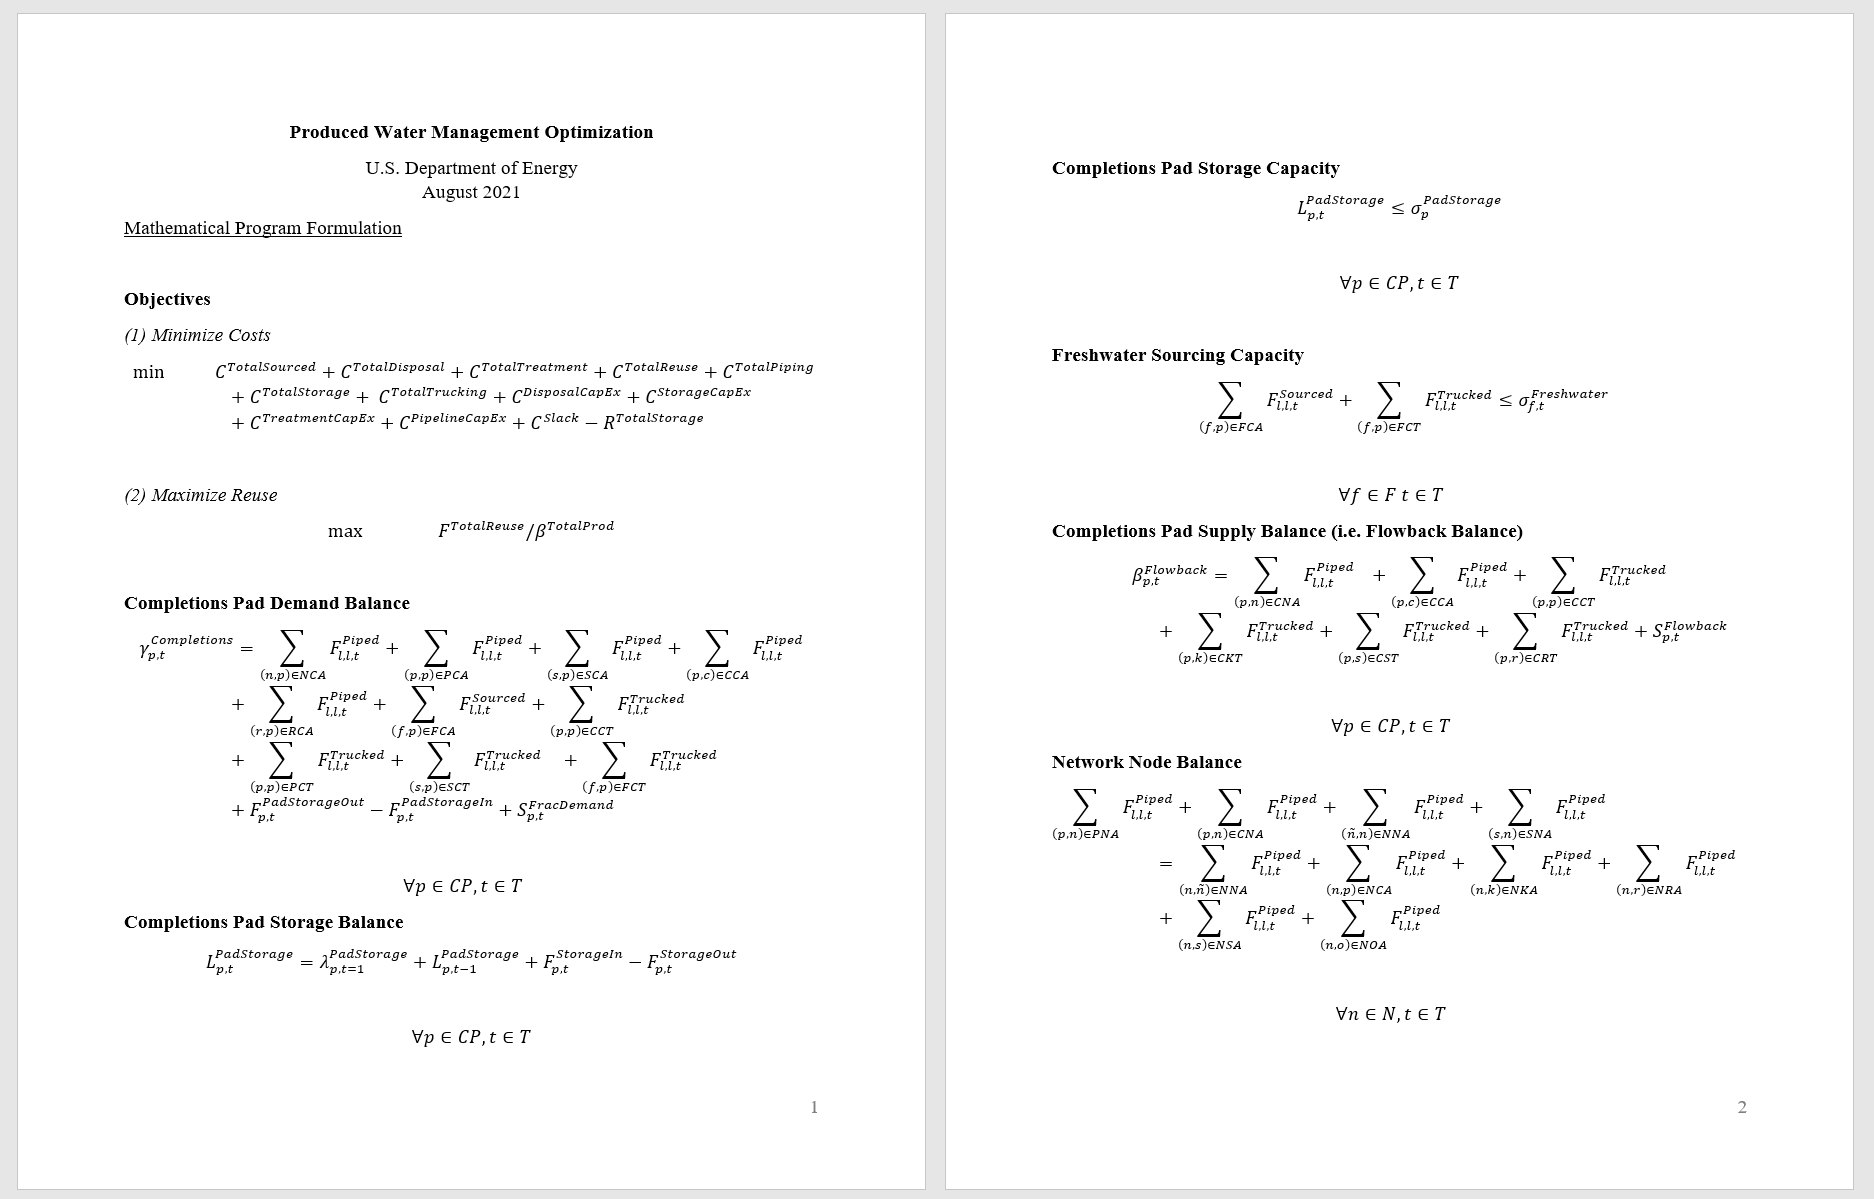

In [3]:
strategic_model = create_variables(model, df_sets, df_parameters, default={"objective": Objectives.cost})

## Define cost objective function ##
if strategic_model.config.objective == Objectives.cost:
    def CostObjectiveFunctionRule(model):
        return model.v_Z == (model.v_C_TotalSourced + model.v_C_TotalDisposal + model.v_C_TotalTreatment + model.v_C_TotalReuse
                            + model.v_C_TotalPiping + model.v_C_TotalStorage + model.v_C_TotalTrucking + model.v_C_DisposalCapEx
                            + model.v_C_StorageCapEx + + model.v_C_TreatmentCapEx + model.v_C_PipelineCapEx + model.v_C_Slack - model.v_R_TotalStorage)
    strategic_model.CostObjectiveFunction = Constraint(rule=CostObjectiveFunctionRule, doc='Cost objective function')

## Define reuse objective function ##
elif strategic_model.config.objective == Objectives.reuse:  
    def ReuseObjectiveFunctionRule(model):
        return model.v_Z == -(model.v_F_TotalReused/model.p_beta_TotalProd) + 1/38446652 * (
                            model.v_C_TotalSourced + model.v_C_TotalDisposal + model.v_C_TotalTreatment + model.v_C_TotalReuse
                            + model.v_C_TotalPiping + model.v_C_TotalStorage + model.v_C_TotalTrucking + model.v_C_DisposalCapEx
                            + model.v_C_StorageCapEx + + model.v_C_TreatmentCapEx + model.v_C_PipelineCapEx + model.v_C_Slack - model.v_R_TotalStorage)
    strategic_model.ReuseObjectiveFunction = Constraint(rule=ReuseObjectiveFunctionRule, doc='Reuse objective function')

else:
    raise Exception('objective not supported')

## Define constraints ##
def CompletionsPadDemandBalanceRule(model,p,t):
    return model.p_gamma_Completions[p,t] == (sum(model.v_F_Piped[n,p,t] for n in model.s_N if model.p_NCA[n,p])
                                            + sum(model.v_F_Piped[p_tilde,p,t] for p_tilde in model.s_PP if model.p_PCA[p_tilde,p])
                                            + sum(model.v_F_Piped[s,p,t] for s in model.s_S if model.p_SCA[s,p])
                                            + sum(model.v_F_Piped[p_tilde,p,t] for p_tilde in model.s_CP if model.p_CCA[p_tilde,p])
                                            + sum(model.v_F_Piped[r,p,t] for r in model.s_R if model.p_RCA[r,p])
                                            + sum(model.v_F_Sourced[f,p,t] for f in model.s_F if model.p_FCA[f,p])
                                            + sum(model.v_F_Trucked[p_tilde,p,t] for p_tilde in model.s_PP if model.p_PCT[p_tilde,p])
                                            + sum(model.v_F_Trucked[p_tilde,p,t] for p_tilde in model.s_CP if model.p_CCT[p_tilde,p])
                                            + sum(model.v_F_Trucked[s,p,t] for s in model.s_S if model.p_SCT[s,p])
                                            + sum(model.v_F_Trucked[f,p,t] for f in model.s_F if model.p_FCT[f,p])
                                            + model.v_F_PadStorageOut[p,t] - model.v_F_PadStorageIn[p,t]
                                            + model.v_S_FracDemand[p,t]) 
strategic_model.CompletionsPadDemandBalance = Constraint(strategic_model.s_CP,strategic_model.s_T,rule=CompletionsPadDemandBalanceRule, doc='Completions pad demand balance')
# create mathematical model
strategic_model = create_model(strategic_model)

print('Optimization model successfully constructed.')


Optimization model successfully constructed.


## Running the Optimization Program

We have now imported all the contextual elements, problem data, and model constraints we need to __run the optimization program__. Next, we therefore solve the optimization problem by executing the code below.

In [4]:
# import pyomo solver
opt = get_solver("cbc")
opt.options['seconds'] = 30
# opt.options['timeLimit'] = 30
opt.options['mipgap'] = 0.04

# solve mathematical model
results = opt.solve(strategic_model, tee=True)
results.write()

print("\nDisplaying Solution\n" + "-" * 60)
[model, results_dict] = generate_report(
    strategic_model,
    is_print=[PrintValues.Essential],
    fname="strategic_optimization_results_demo.xlsx",)

Using license file C:\Users\jamey\gurobi.lic
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LogFile to C:\Users\jamey\AppData\Local\Temp\tmpp7xdxgwf.log
   Prev:   Default: 
Changed value of parameter timeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter mipgap to 0.04
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 31963 rows, 1138711 columns and 200821 nonzeros
Model fingerprint: 0xc1e4d8f9
Variable types: 893629 continuous, 245082 integer (245082 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+11]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 22580 

H  618   377                    3.917765e+07 3.6902e+07  5.81%   184   20s
H  794   522                    3.917435e+07 3.6902e+07  5.80%   176   22s
H  817   522                    3.917233e+07 3.6942e+07  5.69%   173   22s
H 1073   474                    3.884709e+07 3.6977e+07  4.81%   157   26s
H 1075   445                    3.884709e+07 3.6977e+07  4.81%   157   28s

Cutting planes:
  Gomory: 4
  Implied bound: 1
  MIR: 348
  StrongCG: 1
  Flow cover: 133
  RLT: 2
  Relax-and-lift: 1

Explored 1086 nodes (192993 simplex iterations) in 30.51 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 3.88471e+07 3.88471e+07 3.88471e+07 ... 3.92127e+07

Time limit reached
         (possibly due to large matrix coefficients)
Best objective 3.884708801797e+07, best bound 3.697723084991e+07, gap 4.8134%
Changed value of parameter LogFile to 
   Prev: C:\Users\jamey\AppData\Local\Temp\tmpp7xdxgwf.log  Default: 
    containing a solution
# ================================

## Visualizing the Optimization Solution

Next, we visualize the solution that the optimization proposes for the given objective. It is important to note that the program is essentially "extracting" a particular configuration from the superstructure that was postulated initially. This approach is referred to as __"superstructure-based optimization"__. 

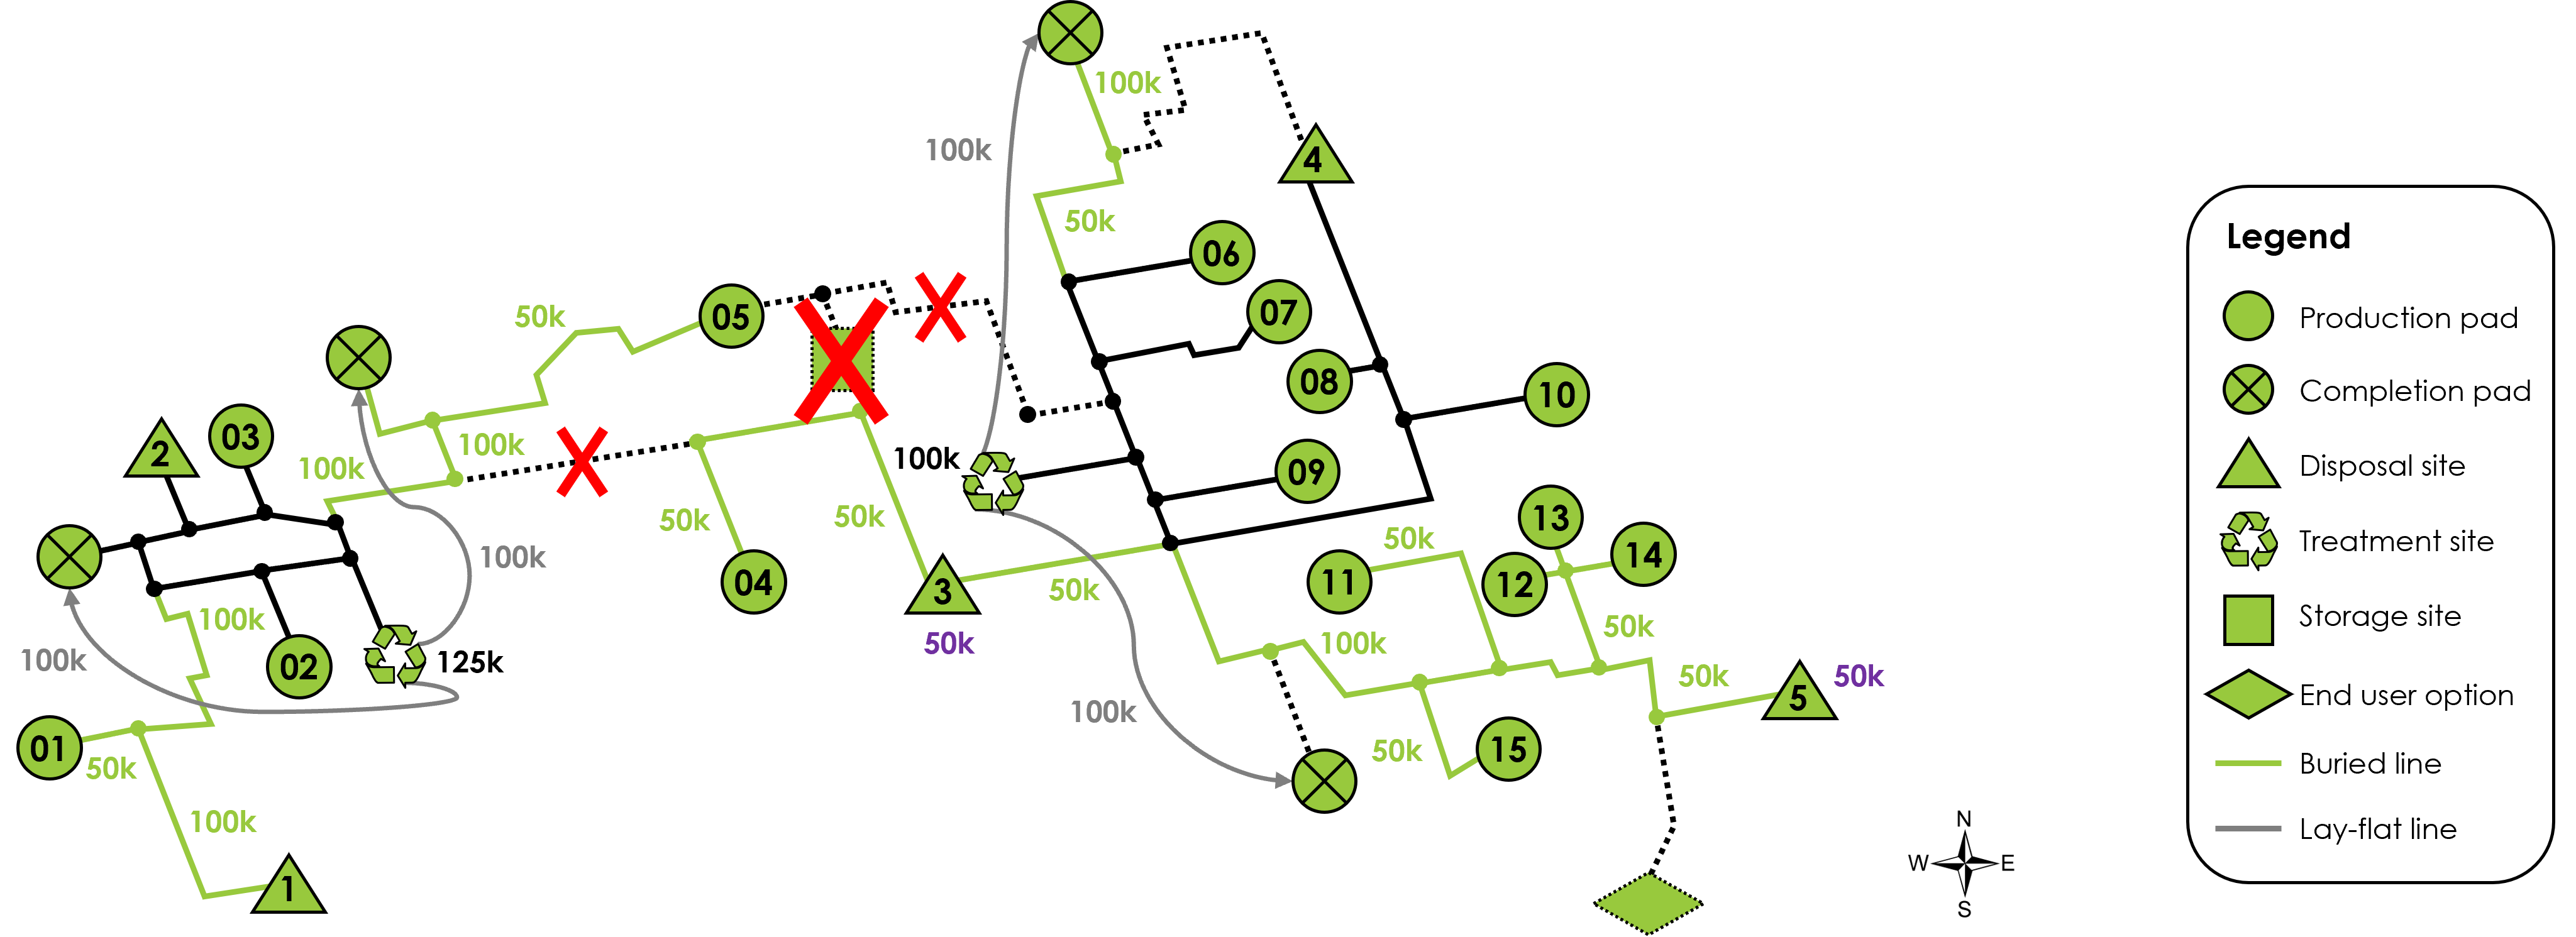

In [6]:
from IPython.display import Image
Image("PossibleSolution.png")

## Source-to-sink Water Flows
Capabilities for plotting water flows as Sankey Diagrams

In [7]:
fname = "strategic_optimization_results.xlsx"
set_list = []
parameter_list = ["v_F_Piped", "v_F_Sourced", "v_L_PadStorage"]
[df_sets, df_parameters_results] = get_data(fname, set_list, parameter_list)

In [8]:
from pareto.utilities.results import plot_sankey
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

args = {"font_size": 15, "plot_title": "FRESH WATER"}
input_data = {
    "pareto_var": df_parameters_results["v_F_Sourced"],
    "labels": [("Origin", "Destination", "Time", "Value")]}
plot_sankey(input_data, args)

### The user has the option to specify what the operation looks like for a specific time period

In [9]:
args = {"font_size": 15, "plot_title": "PIPED WATER"}
input_data = {
    "pareto_var": df_parameters_results["v_F_Piped"],
    "labels": [("Origin", "Destination", "Time", "Value")],
    "time_period": ["T01"]}
plot_sankey(input_data, args)

### It is possible to check the aggregate operation for several time periods too...

In [10]:
input_data = {
    "pareto_var": df_parameters_results["v_F_Piped"],
    "labels": [("Origin", "Destination", "Time", "Value")],
    "time_period": ["T01", "T02", "T03"]}
plot_sankey(input_data, args)

## Checking for variation over time

* Useful for keeping track of the storage tank levels over time
* Support for 3 and 4-indexed variables:
    - Location, Time, Quantity
    - Location, Destination, Time, Quantity

In [11]:
from pareto.utilities.results import plot_bars
args={'chart_title': 'Storage Levels',
      'labels': [('Wellpads', 'Time', 'Storage Level')]}
input_data = {
    "pareto_var": df_parameters_results["v_L_PadStorage"]}
plot_bars(input_data, args=args)
# df_parameters["v_L_PadStorage"]

In [12]:
args={'chart_title': 'PRODUCED WATER OUTPUT',
      'labels': [('Origin', 'Destination', 'Time', 'Piped Water')],
      'y_axis': 'log',
      'group_by': 'Origin'}

wellpads = {k:v for k,v in df_parameters_results["v_F_Piped"].items() if k[0] in model.s_P.data()}
input_data = {
    "pareto_var": wellpads}
plot_bars(input_data, args=args)

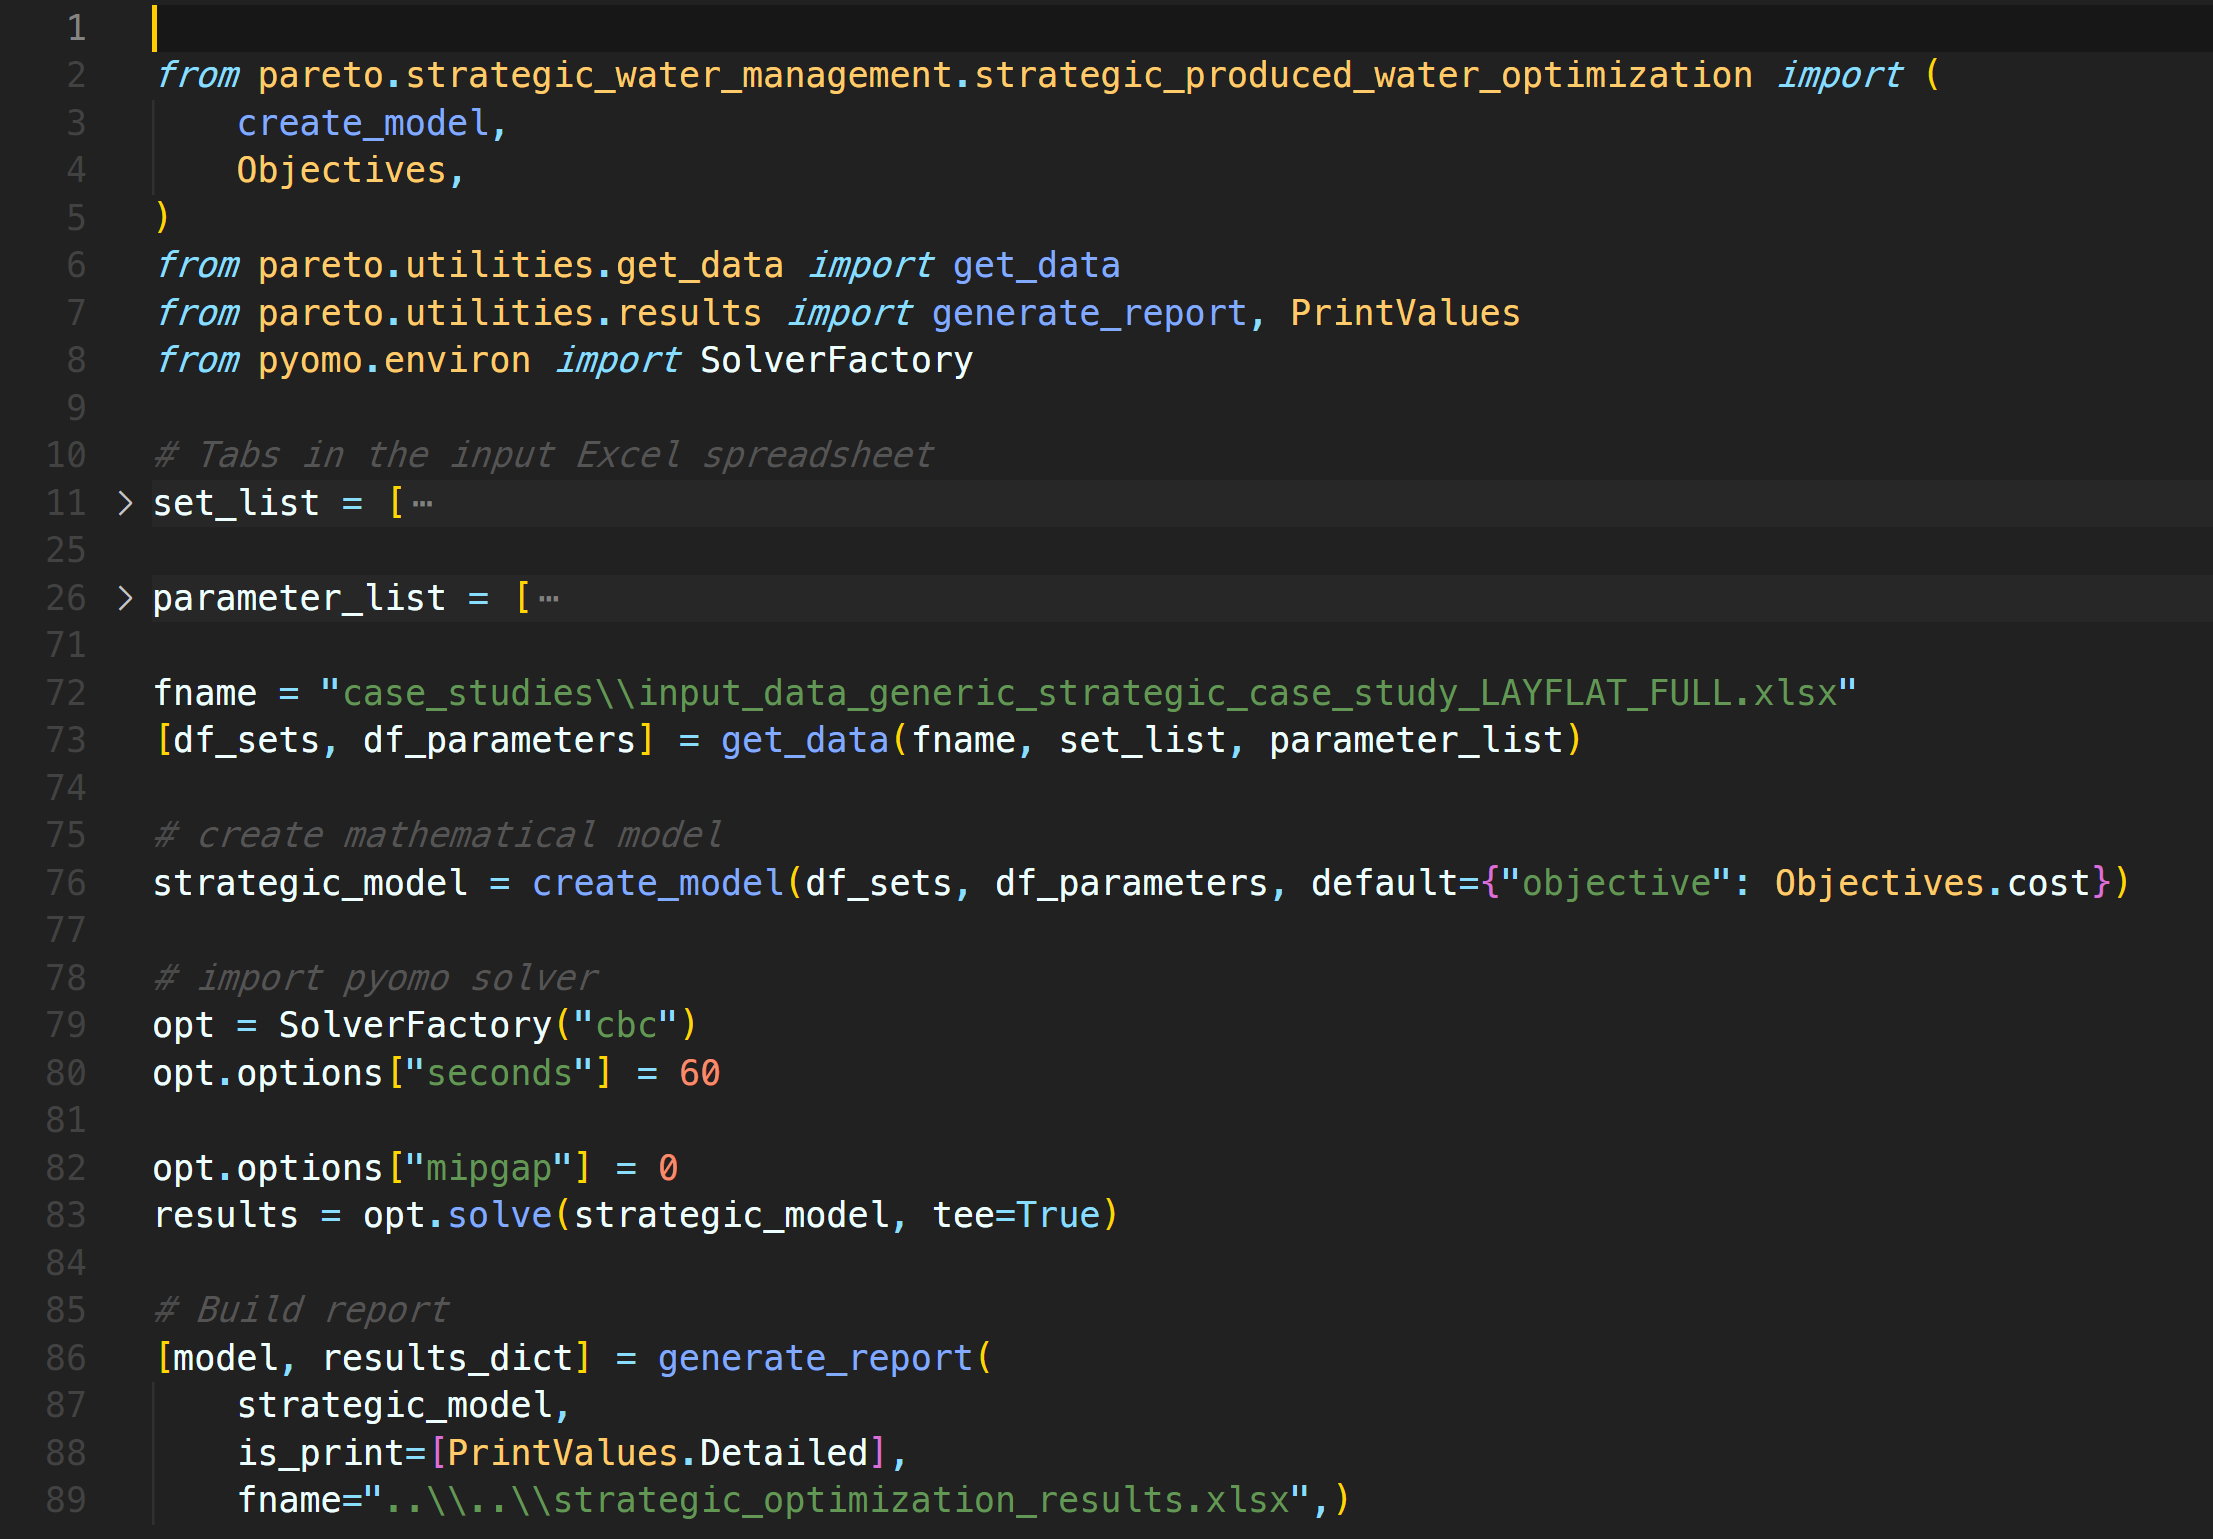

In [13]:
Image("UsingPareto.png")

## Scenario Manager

An important component for PARETO will be the development of an scenario manager, so that the users are able to address how their assets respond to different conditions, such as water demand. For example:

In [15]:

water_demand = [-20, -10, 0, 10, 20]
total_cost = []
fresh_water = []

df_parameters['CompletionsDemand']
print(df_parameters['CompletionsDemand'])


for i in water_demand:
    for p in df_parameters['CompletionsDemand']:

        strategic_model.p_gamma_Completions[p] = df_parameters['CompletionsDemand'][p]*(1+i/100)
        
    print("="*10 +"Running case: Water demand {}%".format(i))
    results = opt.solve(strategic_model, tee=False)
    total_cost.append(strategic_model.v_Z.value)
    fresh_water.append(strategic_model.v_F_TotalSourced.value)

{('CP01', 'T02'): 315000.0, ('CP01', 'T03'): 350000.0, ('CP01', 'T04'): 350000.0, ('CP01', 'T05'): 350000.0, ('CP01', 'T06'): 350000.0, ('CP01', 'T07'): 350000.0, ('CP01', 'T08'): 350000.0, ('CP01', 'T09'): 350000.0, ('CP01', 'T10'): 350000.0, ('CP01', 'T11'): 260000.0, ('CP02', 'T22'): 280000.0, ('CP02', 'T23'): 300000.0, ('CP02', 'T24'): 300000.0, ('CP02', 'T25'): 300000.0, ('CP02', 'T26'): 300000.0, ('CP02', 'T27'): 300000.0, ('CP02', 'T28'): 300000.0, ('CP02', 'T29'): 300000.0, ('CP02', 'T30'): 300000.0, ('CP02', 'T31'): 300000.0, ('CP02', 'T32'): 300000.0, ('CP02', 'T33'): 300000.0, ('CP02', 'T34'): 300000.0, ('CP02', 'T35'): 150000.0, ('CP03', 'T13'): 140000.0, ('CP03', 'T14'): 325000.0, ('CP03', 'T15'): 325000.0, ('CP03', 'T16'): 325000.0, ('CP03', 'T17'): 325000.0, ('CP03', 'T18'): 325000.0, ('CP03', 'T19'): 325000.0, ('CP03', 'T20'): 65000.0, ('CP04', 'T36'): 75000.0, ('CP04', 'T37'): 320000.0, ('CP04', 'T38'): 320000.0, ('CP04', 'T39'): 320000.0, ('CP04', 'T40'): 320000.0, ('

In [61]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=water_demand, y=total_cost,
                        mode='lines+markers',
                        name='Total Cost'),
                 secondary_y=False)
fig.add_trace(go.Scatter(x=water_demand, y=fresh_water,
                        mode='lines+markers',
                        name='Fresh Water Consumption'),
                secondary_y=True)

# Add figure title
fig.update_layout(
    title={
        'text': "Sensitivity Analysis",
        'y':0.86,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

# Set x-axis title
fig.update_xaxes(title_text="Water Demand Variation [%]")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Total Cost</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Fresh Water Demand</b>", secondary_y=True)

fig.show()